In [10]:
import numpy.random as rand
from scipy.fftpack import *
from scipy.signal import *
import numpy as np
from fundfunctions import *
pi = np.pi

In [11]:
def gauss(t, fwhm, a, dt):
    return a*np.exp(-4*np.log(2)*((t+dt)/fwhm)**2)

def findN(bw, nch, T):
    N0 = bw*T
    if N0%(2048*nch) == 0:
        return N0
    else:
        return int(np.ceil(N0/(2048*nch))*nch*2048)

def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

NANOGrav observations with PUPPI/GUPPI:
Center frequency (MHz)       Bandwidth (MHz)      # of channels
820                          200                  128
1520                         800                  512
2230                         400                  256
-> channel width ~ 1.5 MHz

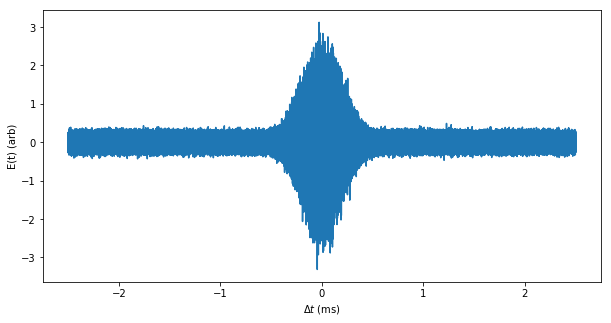

In [12]:
# Starting pulse
T = 5e-3 # period in seconds
fc = 1.52e9 # center frequency in Hz
bw = 800e6 # total bandwidth in Hz
nch = 512 # number of channels
nsam = findN(bw, nch, T) # number of samples
t = np.linspace(-T/2., T/2., nsam) # time axis
dt = T/nsam # sampling interval
template = gauss(t, 5e-4, 3, 0.) # gaussian template
pulse = 0.25*template*rand.randn(nsam) + 0.1*rand.randn(nsam) # tried using Poisson noise, but white noise looks
                                                              # better to me
hetpulse = pulse*np.exp(1j*2*pi*t*fc) # heterodyne to center frequency
plt.figure(figsize = (10, 5))
plt.plot(t*1e3, hetpulse.real)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('E(t) (arb)')
plt.show()

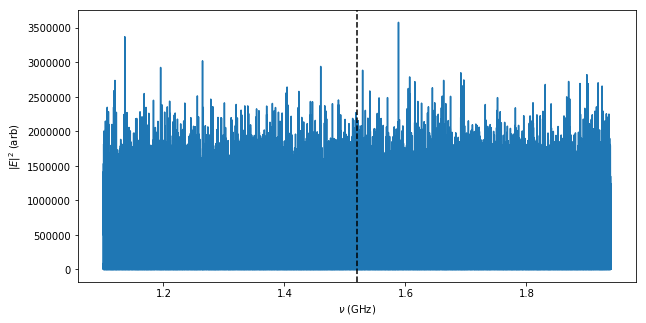

In [13]:
ft = fftshift(fft(hetpulse)) # Fourier transform is centered at fc due to multiplication with exp(iw_0t)
freq = fftfreq(nsam, d = dt)
plt.figure(figsize = (10, 5))
plt.plot(freq/1e9 + fc/1e9, np.abs(ft)**2)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$|E|^2$ (arb)')
plt.axvline(x = fc/1e9, ls = 'dashed', color = 'black')
plt.show()

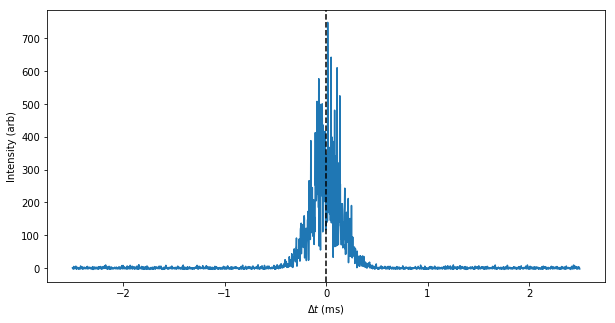

In [14]:
# Pulse associated with a single channel
spl = np.split(ft, nch) # split spectrum into segments with length depending on total number of channels
freqs = np.split(freq + fc, nch) 
ift = ifft(ifftshift(spl[0])) # take inverse Fourier transform using sampled frequencies inside channel
I = groupedAvg(np.abs(ift)**2, N = nsam/(2048*nch)) # average from 8192 bins down to 2048 bins 
I = I - np.mean(I[:100]) # substract base noise
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(-T/2., T/2., 2048)*1e3, I)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('Intensity (arb)')
plt.axvline(x = 0, color = 'black', ls = 'dashed')
plt.show()

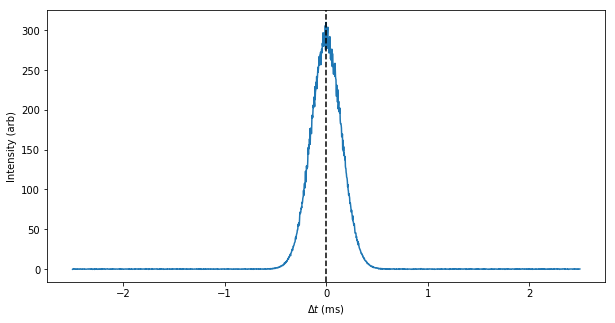

In [15]:
# Average over all channels to construct averaged pulse for entire bandwidth
newpulse = np.zeros(2048)
for i in range(len(spl)):
    ift = ifft(ifftshift(spl[i]))
    I = groupedAvg(np.abs(ift)**2, N = nsam/(2048*nch))
    I = I - np.mean(I[:100])
    newpulse = newpulse + I
newpulse = newpulse/nch
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(-2.5, 2.5, 2048), newpulse)
plt.axvline(x = 0, color = 'black', ls = 'dashed')
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('Intensity (arb)')
plt.show()

Magnitude of averaged intensity looks too large given the initial amplitude of the electric field pulse. Not sure whether I am missing a normalizing factor somewhere.

Ideally would calculate $A(\nu)*exp(i*\phi (\nu))$ due to the lens for the complete frequency band and then perform inverse transforms using the frequencies of each individual channel, summing the values in the cases of multiple imaging, but the number of required calculations is too large. For a single channel, the number of samples is 8192, so directly calculating the quantities for even a single channel would be computationally expensive. My idea was to expand $\phi(\nu)$ and $A(\nu)$ for each image at the channel center frequency in a Taylor series, thus actually solving the lens equation only once per channel, significantly reducing the computational complexity. Not sure how to show that this is a good approximation.